# Unsupervised outlier detection for Time series data using LSTM + AE
Feature : TIME,TMP,HMD,TVOC,CO,CO2,CH2O,PM10 (8 features)   
Time : 2022-05-01 ~ 2022-05-19

## 0. Setting

In [1]:
pwd

'C:\\myPyCode\\AI_DATA\\Outlier Detection'

### Library Call

In [4]:
from glob import glob
import os

import pandas as pd
import numpy as np
import datetime
import time

import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

matplotlib.rcParams['font.family']='Malgun Gothic'  # 한글 폰트 패치.
matplotlib.rcParams['axes.unicode_minus'] = False   

import warnings
warnings.filterwarnings('ignore')   # 경고문 처리.

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from keras import backend
from functools import partial
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Activation, Flatten, Dense
from keras import layers, models
from keras.utils import np_utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture

### User Function Definition

In [31]:
# BoxplotEDA Function Definition
def boxplotEDA(data,cols,nrow,ncol):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  plt.suptitle('Box Plot EDA',size=30, y=0.92)
  i=0
  for col in cols:
    sns.boxplot(y = df[col], ax=ax[i//ncol,i%ncol], palette='Set3', linewidth=1.5)
    i+=1  

# Sublineplot
def subplots(data,cols,nrow,ncol):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  plt.suptitle('Subplot EDA',size=30, y=0.92)
  i=0
  for col in cols:
    ax[i//ncol,i%ncol].plot(df[col])
    ax[i//ncol,i%ncol].set_ylabel(col)
    i+=1  
  
# lineplot
def lineplot(data,cols):
  df = data[cols]
  plt.figure(figsize=(20,10))
  plt.title('Lineplot', size=25)
  for col in cols:
    plt.plot(df[col], label=col)
  plt.legend(loc='upper right')  

# corr_matrix
def corr_matrix(data, cols):
  df = data[cols]
  colormap = plt.cm.PuBu 
  plt.figure(figsize=(12, 12)) 
  plt.title('Correlation Matrix', size=25)
  sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
              square = True, cmap = colormap, linecolor = "white", annot = True, fmt='.2f',
              annot_kws = {"size" : 12})
  plt.show()

## 1. Data Load

### Device 11

In [179]:
filst = sorted(glob('C:\\myPyCode\\AI_DATA\\Outlier Detection\\data\\*.csv'))
filst

['C:\\myPyCode\\AI_DATA\\Outlier Detection\\data\\device11_5_1_5_25.csv',
 'C:\\myPyCode\\AI_DATA\\Outlier Detection\\data\\device16_5_1_5_25.csv',
 'C:\\myPyCode\\AI_DATA\\Outlier Detection\\data\\df11.csv']

In [7]:
device11 = pd.read_csv(filst[0])
device16 = pd.read_csv(filst[1])

In [8]:
print(device11.shape)
device11.head()

(17090, 17)


DeviceName                              EntityId                TsYMD  \
0  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:01:08   
1  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:03:08   
2  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:05:08   
3  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:07:09   
4  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:09:09   

   CH2O  PM2.5  PM10    TVOC    CO2  Temperature  Humidity  Radioactivity  \
0  25.0   10.0  18.0  1377.0  545.0        23.27     21.45            0.0   
1  25.0   10.0  19.0  1377.0  544.0        20.51     21.46            0.0   
2  25.0   10.0  18.0  1383.0  546.0        21.87     21.46            0.0   
3  25.0   10.0  18.0  1374.0  547.0        21.87     21.48            0.0   
4  25.0   10.0  18.0  1380.0  548.0        21.86     21.48            0.0   

   Sound    CO  Stink   NO2  H2S  NH3  
0   38.0  0.99   0.03  0.01  0.0  0.0  
1   33.0  0.82   0.03  0.01  0.0  0.0  
2   33.0  0.50   0.03  0.01  0.0  0.0  
3   36.0  0.52   0.03  0.01  0.0  0.0  
4   35.0  0.37   0.03  0.01  0.0  0.0

In [9]:
device11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17090 entries, 0 to 17089
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DeviceName     17090 non-null  object 
 1   EntityId       17090 non-null  object 
 2   TsYMD          17090 non-null  object 
 3   CH2O           17090 non-null  float64
 4   PM2.5          17090 non-null  float64
 5   PM10           17090 non-null  float64
 6   TVOC           17090 non-null  float64
 7   CO2            17090 non-null  float64
 8   Temperature    17090 non-null  float64
 9   Humidity       17090 non-null  float64
 10  Radioactivity  17090 non-null  float64
 11  Sound          17090 non-null  float64
 12  CO             17090 non-null  float64
 13  Stink          17090 non-null  float64
 14  NO2            17090 non-null  float64
 15  H2S            17090 non-null  float64
 16  NH3            17090 non-null  float64
dtypes: float64(14), object(3)
memory usage: 2.2+ MB


In [10]:
device11.describe()

CH2O         PM2.5          PM10          TVOC           CO2  \
count  17090.000000  17090.000000  17090.000000  17090.000000  17090.000000   
mean      28.538268      6.259450     10.744470   2225.640316    549.528672   
std       13.051426      6.034512     11.267901   1069.545831    113.073053   
min        0.000000      0.000000      0.000000      0.000000    400.000000   
25%       22.000000      3.000000      5.000000   1357.000000    450.000000   
50%       28.000000      4.000000      7.000000   2104.500000    547.000000   
75%       35.000000      8.000000     14.000000   2946.000000    624.000000   
max      333.000000     74.000000    137.000000   7034.000000   1476.000000   

        Temperature      Humidity  Radioactivity         Sound            CO  \
count  17090.000000  17090.000000        17090.0  17090.000000  17090.000000   
mean      24.076917     20.231280            0.0     40.425102      0.645453   
std        2.279940      3.350303            0.0      3.729020      0.126773   
min       17.350000      9.660000            0.0     27.000000      0.000000   
25%       22.430000     17.740000            0.0     38.000000      0.560000   
50%       23.860000     20.250000            0.0     41.000000      0.640000   
75%       25.520000     22.100000            0.0     43.000000      0.720000   
max       33.620000     32.040000            0.0     60.000000      1.540000   

              Stink           NO2      H2S      NH3  
count  17090.000000  17090.000000  17090.0  17090.0  
mean       0.027205      0.009879      0.0      0.0  
std        0.004499      0.001091      0.0      0.0  
min        0.000000      0.000000      0.0      0.0  
25%        0.020000      0.010000      0.0      0.0  
50%        0.030000      0.010000      0.0      0.0  
75%        0.030000      0.010000      0.0      0.0  
max        0.030000      0.010000      0.0      0.0

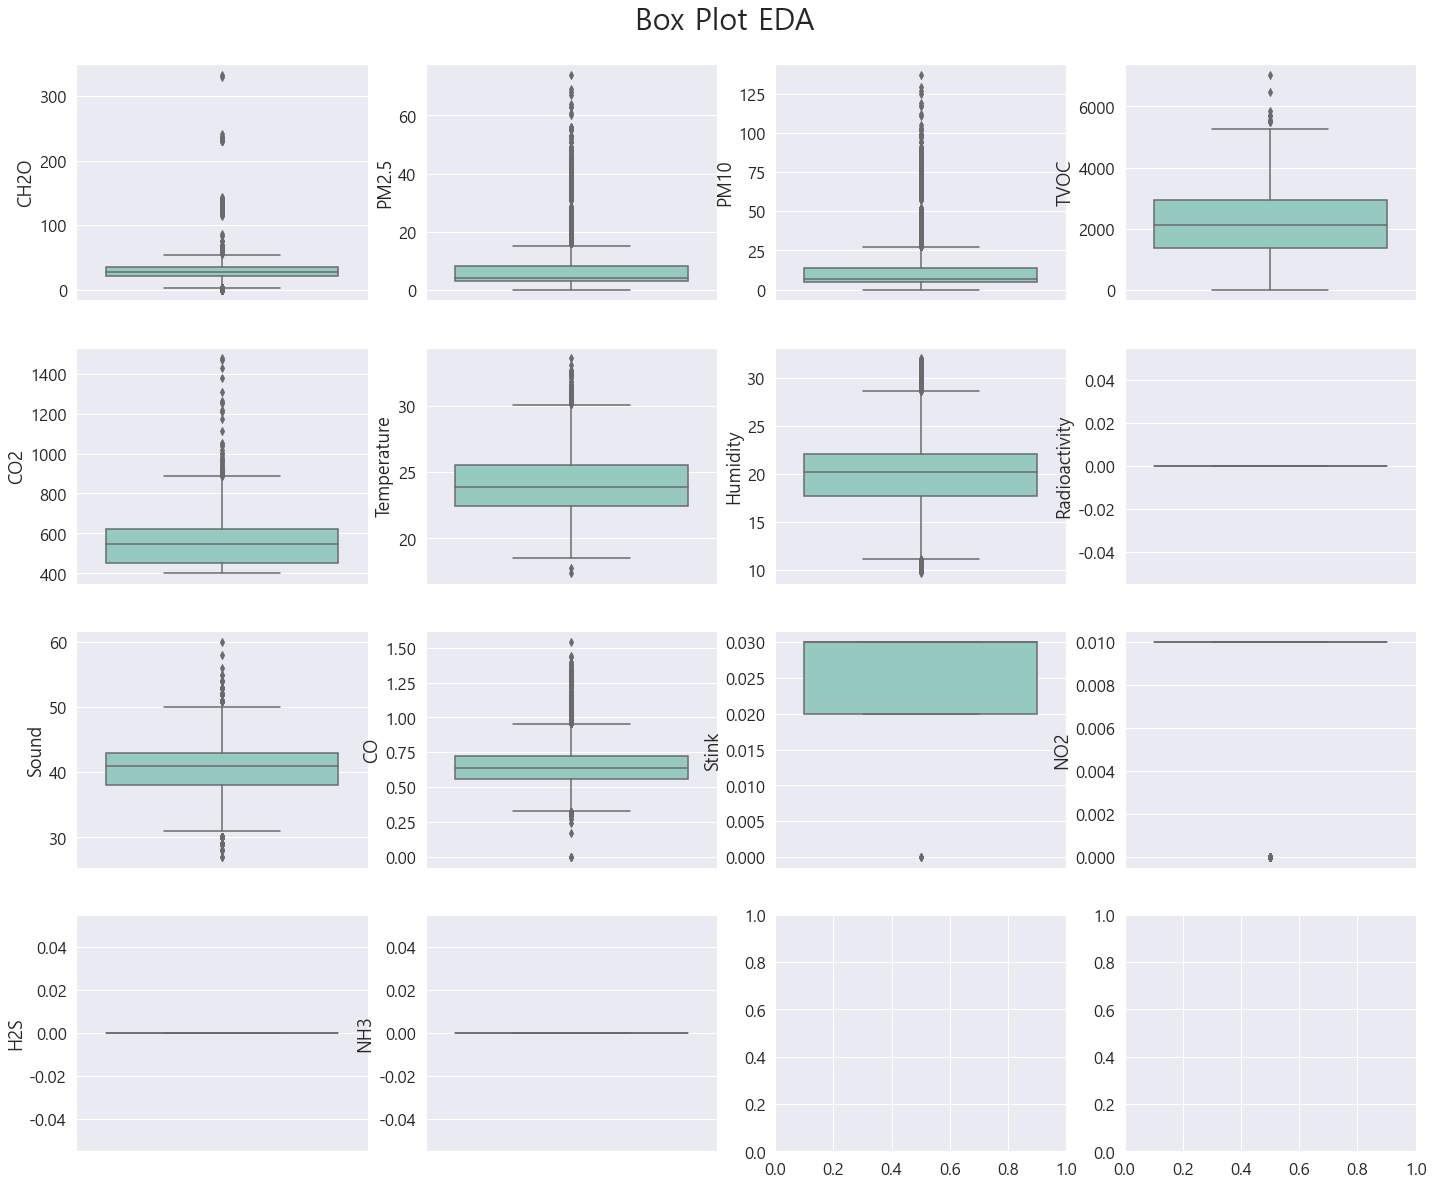

In [23]:
boxplotEDA(device11,device11.columns[3:],4,4)

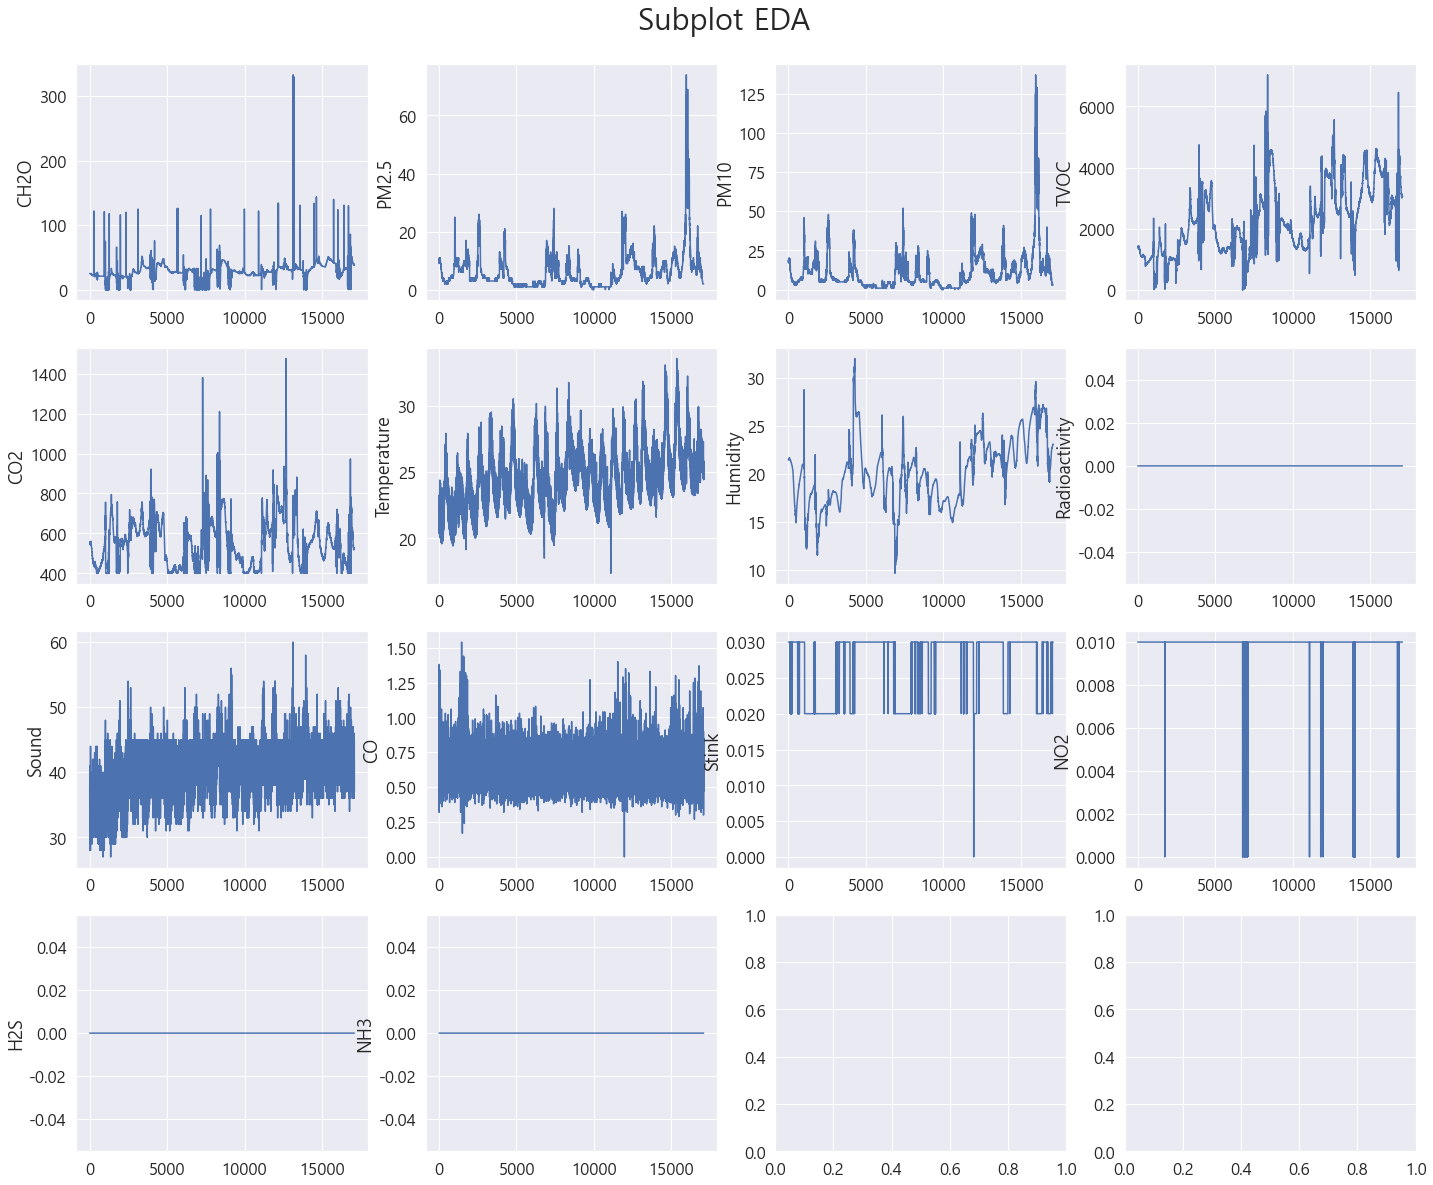

In [32]:
subplots(device11,device11.columns[3:],4,4)

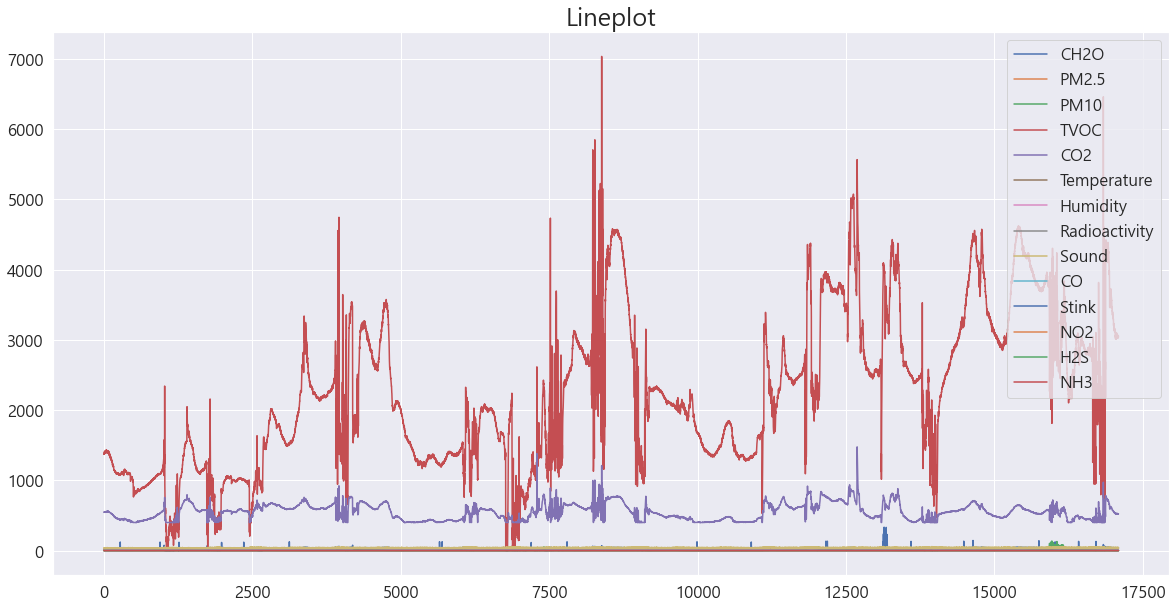

In [33]:
lineplot(device11, device11.columns[3:])

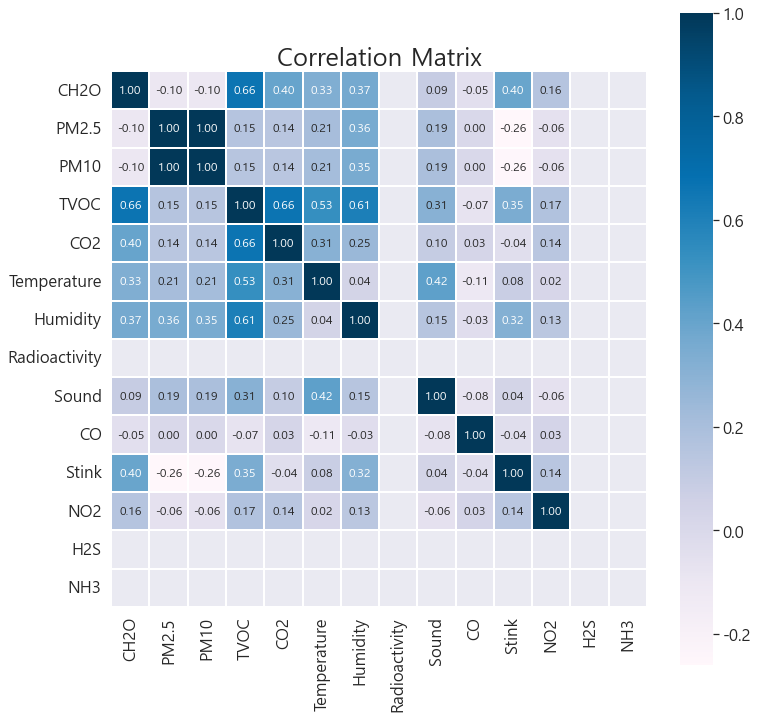

In [34]:
corr_matrix(device11, device11.columns[3:])

### Device 16

In [35]:
print(device16.shape)
device16.head()

(16954, 17)


DeviceName                              EntityId                TsYMD  \
0  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:01:42   
1  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:03:42   
2  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:05:42   
3  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:07:43   
4  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:09:43   

   CH2O  PM2.5  PM10    TVOC    CO2  Temperature  Humidity  Radioactivity  \
0  41.0   10.0  19.0  1441.0  511.0        21.05     21.64            0.0   
1  41.0   10.0  18.0  1428.0  514.0        23.79     21.64            0.0   
2  41.0    9.0  16.0  1471.0  516.0        22.41     21.64            0.0   
3  41.0   10.0  18.0  1463.0  518.0        21.02     21.63            0.0   
4  41.0   10.0  18.0  1464.0  517.0        22.40     21.66            0.0   

   Sound   CO  Stink  NO2  H2S  NH3  
0   37.0  0.0    0.0  0.0  0.0  0.0  
1   35.0  0.0    0.0  0.0  0.0  0.0  
2   33.0  0.0    0.0  0.0  0.0  0.0  
3   38.0  0.0    0.0  0.0  0.0  0.0  
4   34.0  0.0    0.0  0.0  0.0  0.0

In [36]:
device16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16954 entries, 0 to 16953
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DeviceName     16954 non-null  object 
 1   EntityId       16954 non-null  object 
 2   TsYMD          16954 non-null  object 
 3   CH2O           16954 non-null  float64
 4   PM2.5          16954 non-null  float64
 5   PM10           16954 non-null  float64
 6   TVOC           16954 non-null  float64
 7   CO2            16954 non-null  float64
 8   Temperature    16954 non-null  float64
 9   Humidity       16954 non-null  float64
 10  Radioactivity  16954 non-null  float64
 11  Sound          16954 non-null  float64
 12  CO             16954 non-null  float64
 13  Stink          16954 non-null  float64
 14  NO2            16954 non-null  float64
 15  H2S            16954 non-null  float64
 16  NH3            16954 non-null  float64
dtypes: float64(14), object(3)
memory usage: 2.2+ MB


In [37]:
device16.describe()

CH2O         PM2.5          PM10          TVOC           CO2  \
count  16954.000000  16954.000000  16954.000000  16954.000000  16954.000000   
mean      48.533915      6.273328     10.713342   2257.573847    543.657839   
std       17.727884      5.210495      9.692058   1145.194732    108.421800   
min       10.000000      1.000000      1.000000      0.000000    400.000000   
25%       37.000000      3.000000      5.000000   1299.250000    443.000000   
50%       46.000000      5.000000      8.000000   2120.000000    545.000000   
75%       60.000000      8.000000     13.000000   3060.000000    616.000000   
max      225.000000     69.000000    127.000000   8611.000000   1311.000000   

        Temperature      Humidity  Radioactivity         Sound            CO  \
count  16954.000000  16954.000000        16954.0  16954.000000  16954.000000   
mean      23.988897     20.907153            0.0     34.675239      0.240119   
std        2.025520      3.186919            0.0      4.719826      0.118233   
min       19.090000     10.950000            0.0     26.000000      0.000000   
25%       22.490000     18.510000            0.0     31.000000      0.210000   
50%       23.830000     20.830000            0.0     34.000000      0.260000   
75%       25.350000     22.790000            0.0     37.000000      0.310000   
max       31.460000     31.270000            0.0     59.000000      0.840000   

              Stink           NO2      H2S           NH3  
count  16954.000000  16954.000000  16954.0  16954.000000  
mean       0.398862      0.008459      0.0      0.278223  
std        0.175390      0.003611      0.0      0.448137  
min        0.000000      0.000000      0.0      0.000000  
25%        0.430000      0.010000      0.0      0.000000  
50%        0.450000      0.010000      0.0      0.000000  
75%        0.470000      0.010000      0.0      1.000000  
max        0.600000      0.010000      0.0      1.000000

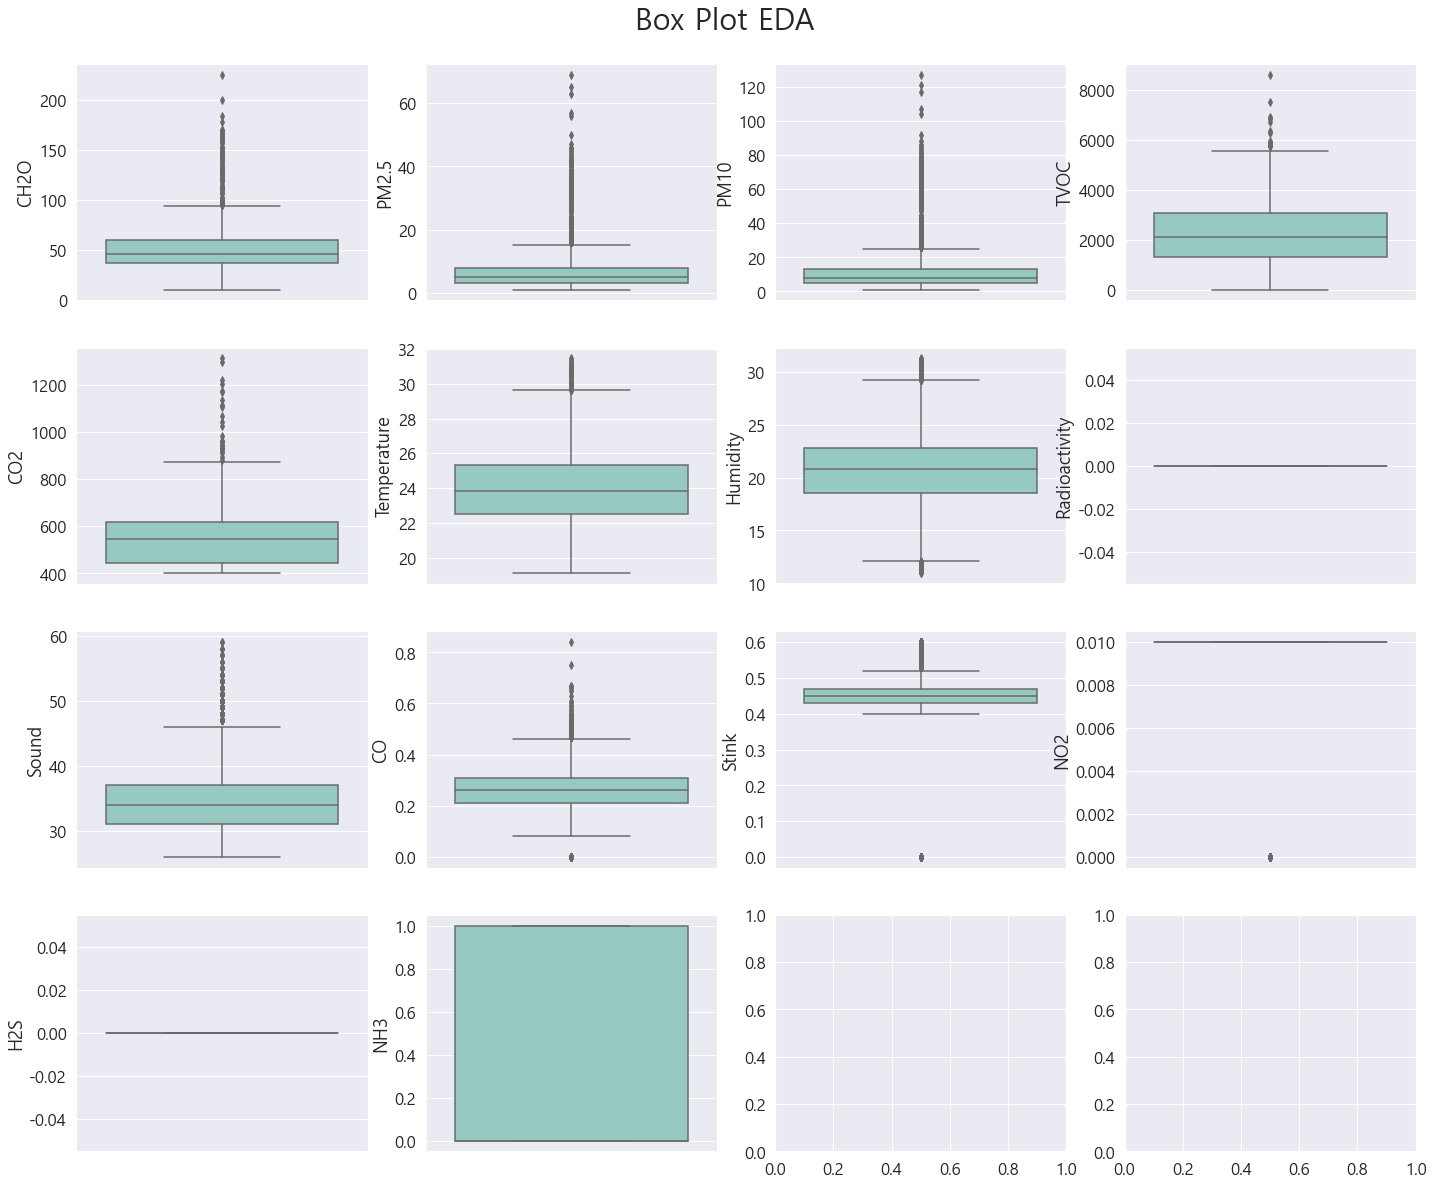

In [38]:
boxplotEDA(device16,device16.columns[3:],4,4)

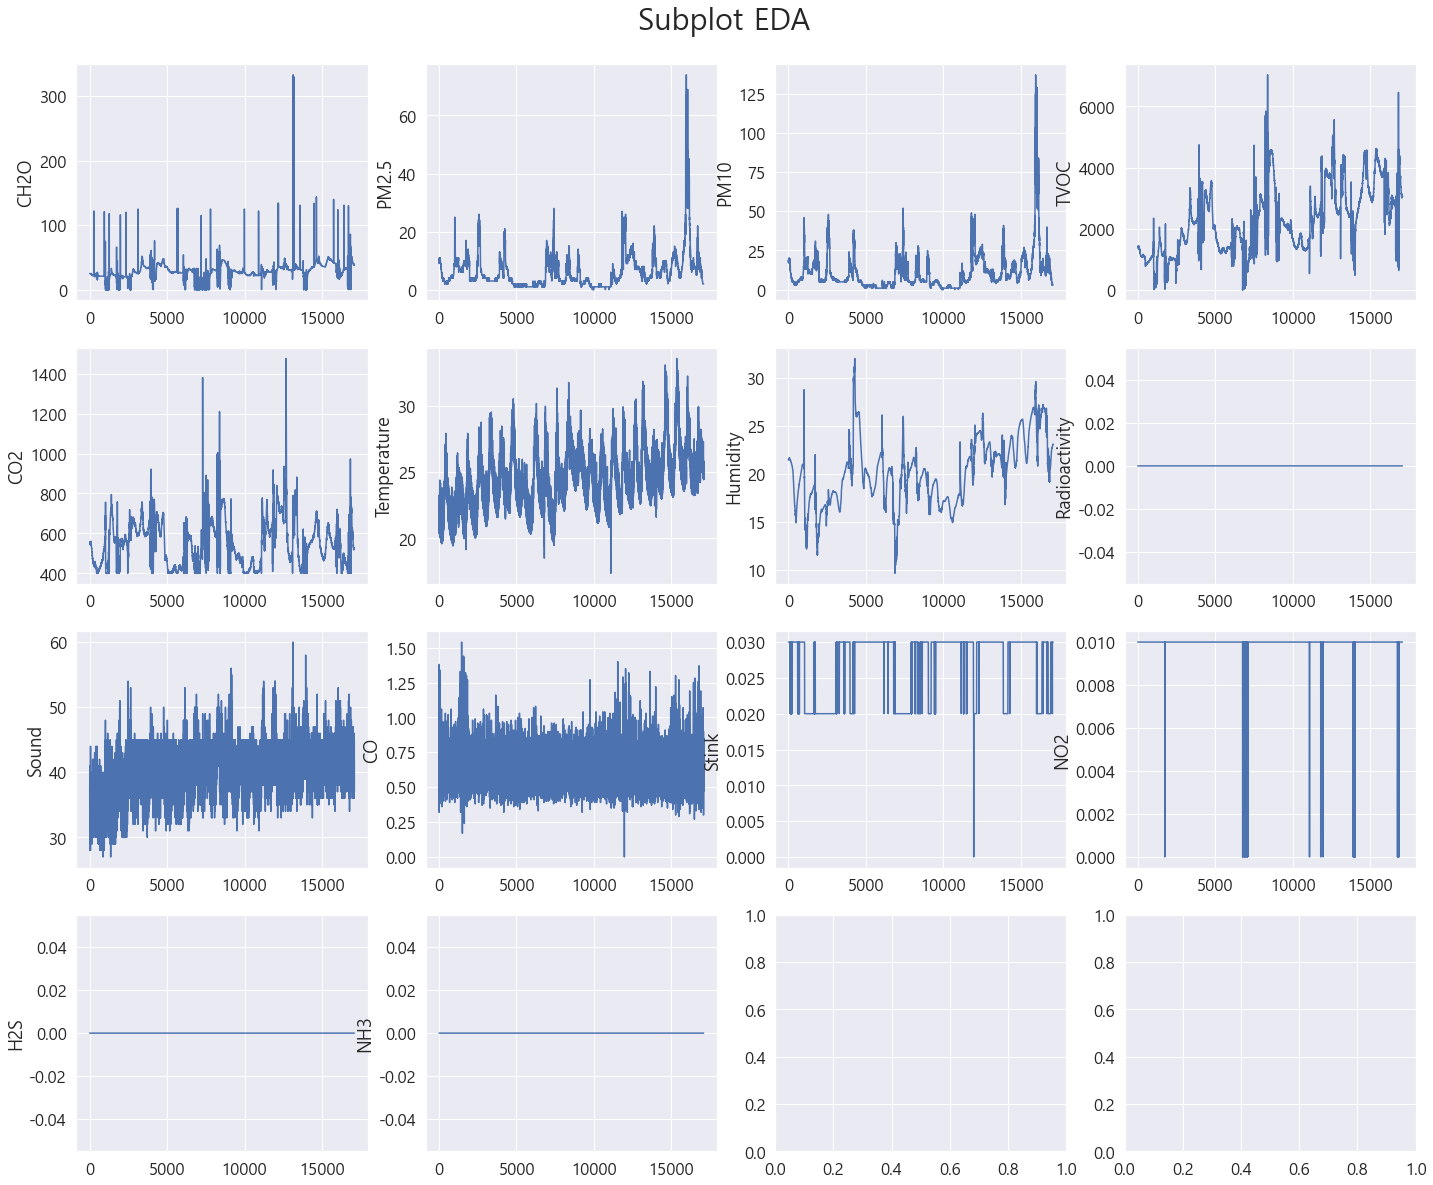

In [39]:
subplots(device11,device11.columns[3:],4,4)

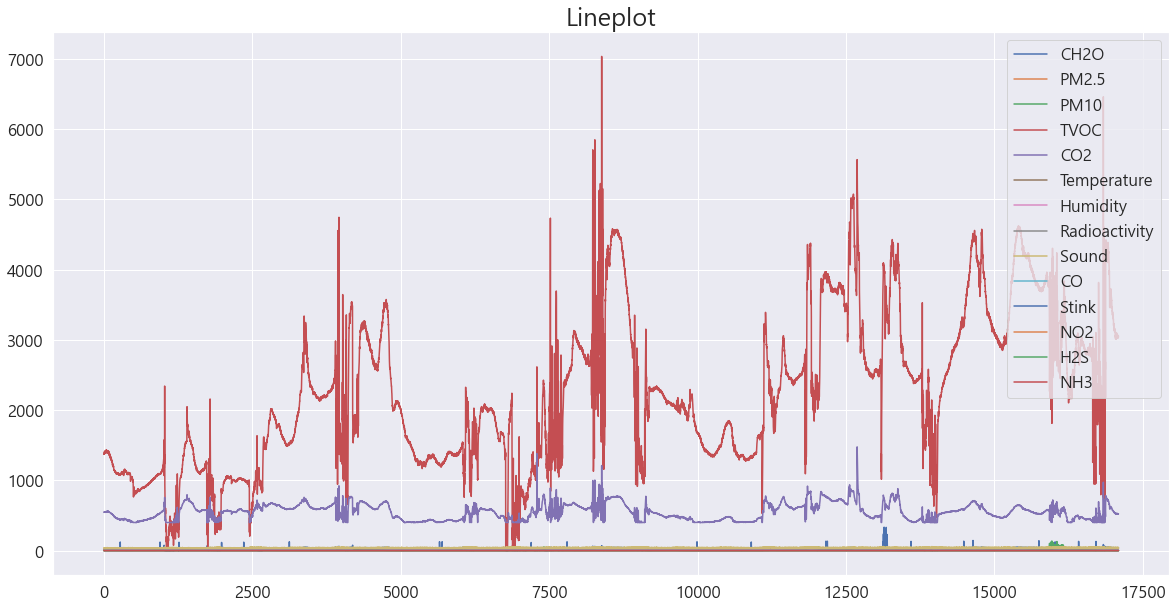

In [40]:
lineplot(device11, device11.columns[3:])

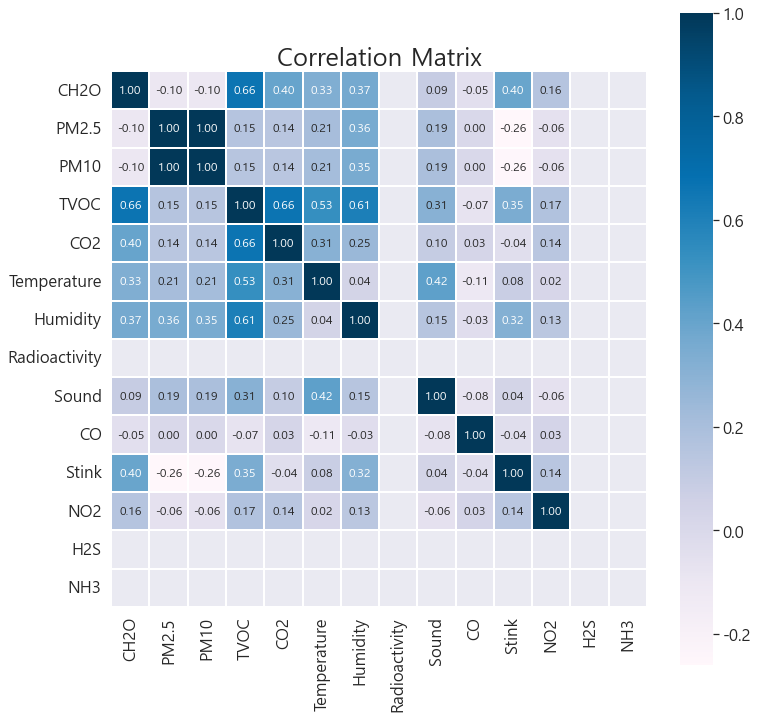

In [41]:
corr_matrix(device11, device11.columns[3:])

## 2. Data Prprocessing

### Data Feature Selection

In [42]:
d11=device11.copy()
d16=device16.copy()

In [43]:
d11.columns

Index(['DeviceName', 'EntityId', 'TsYMD', 'CH2O', 'PM2.5', 'PM10', 'TVOC',
       'CO2', 'Temperature', 'Humidity', 'Radioactivity', 'Sound', 'CO',
       'Stink', 'NO2', 'H2S', 'NH3'],
      dtype='object')

In [44]:
d11 = d11[['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']]
d16 = d16[['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']]
print('d11.shape :',d11.shape)
print('d16.shape :',d16.shape)

d11.shape : (17090, 8)
d16.shape : (16954, 8)


### Separate device because of long term over 2min


이거 해주는 이유 바로 아래 코드 보면 이해됨.  
2022-04-13 04:27 | 2022-04-13 10:18 사이 공백 발생 -> 공백 발생하는 곳마다 여러개의 dataframe으로 나눠 진행 필요

In [45]:
d11['TsYMD'][4127:4131]
#d16['TsYMD'][8509:8513]

4127    2022-05-06 17:39:54
4128    2022-05-06 17:41:54
4129    2022-05-06 17:43:54
4130    2022-05-06 17:45:54
Name: TsYMD, dtype: object

여기부터 진행

In [46]:
d11['TsYMD']=pd.to_datetime(d11['TsYMD'])
d11=d11.sort_values('TsYMD')
d11['TsYMD']=d11['TsYMD'].dt.to_period(freq='min')
time =d11['TsYMD'].apply(lambda x: x.strftime('%Y%m%d%H%M'))

In [47]:
time.head()

0    202205010001
1    202205010003
2    202205010005
3    202205010007
4    202205010009
Name: TsYMD, dtype: object

In [48]:
from datetime import datetime
check_list=[0]
for i in range(1,len(time)):
  now=datetime.strptime(time[i],'%Y%m%d%H%M')
  past=datetime.strptime(time[i-1],'%Y%m%d%H%M')
  diff=now-past
  diff=diff.seconds/60
  if diff >6:
    check_list.append(i)
check_list.append(len(time))

In [49]:
check_list

[0, 12724, 13035, 13047, 13081, 13128, 17090]

In [50]:
# check 한 번 해주기.
for i in range(len(check_list)):
  print(d11['TsYMD'][check_list[i]-1:check_list[i]+1])

Series([], Name: TsYMD, dtype: period[T])
12723    2022-05-18 16:21
12724    2022-05-18 18:00
Name: TsYMD, dtype: period[T]
13034    2022-05-19 07:08
13035    2022-05-19 07:17
Name: TsYMD, dtype: period[T]
13046    2022-05-19 07:49
13047    2022-05-19 07:59
Name: TsYMD, dtype: period[T]
13080    2022-05-19 09:21
13081    2022-05-19 09:29
Name: TsYMD, dtype: period[T]
13127    2022-05-19 11:20
13128    2022-05-19 11:53
Name: TsYMD, dtype: period[T]
17089    2022-05-24 23:59
Name: TsYMD, dtype: period[T]


In [51]:
d11_1=d11[check_list[0]:check_list[1]]
d11_2=d11[check_list[1]+1:check_list[2]]
d11_3=d11[check_list[2]+1:check_list[3]]
d11_4=d11[check_list[3]+1:check_list[4]]
d11_5=d11[check_list[4]+1:check_list[5]]

device11 -> d11_1, d11_2, d11_3, d11_4, d11_5로 나눠 진행

In [52]:
d11_5.head()

TsYMD  Temperature  Humidity    TVOC    CO    CO2  CH2O  \
13082  2022-05-19 09:32        24.23     21.70  2691.0  0.59  502.0  31.0   
13083  2022-05-19 09:33        24.26     21.66  2658.0  0.50  501.0  31.0   
13084  2022-05-19 09:35        25.66     21.66  2697.0  0.65  504.0  31.0   
13085  2022-05-19 09:40        25.70     21.64  2720.0  0.80  504.0  32.0   
13086  2022-05-19 09:42        24.37     21.59  2695.0  0.63  501.0  31.0   

       PM10  
13082   9.0  
13083   8.0  
13084  10.0  
13085   9.0  
13086  10.0

### Time Synchronization (2 min)

In [53]:
import datetime

def deviceEDA(device):
  device.reset_index(drop=True,inplace=True)
  time =device['TsYMD'].apply(lambda x: x.strftime('%Y%m%d%H%M'))
  time.reset_index(drop=True,inplace=True)
  for i in range(len(device['TsYMD'])):
    if int(time[i][-2:])%2 ==1:
      device['TsYMD'][i]=device['TsYMD'][i]+datetime.timedelta(minutes=1)
  return device

def frameEDA(device):
  frame = pd.date_range(start = device['TsYMD'].iloc[0].strftime('%Y-%m-%d %H:%M'),            # 날짜 범위 시작
                     end = device['TsYMD'].iloc[-1].strftime('%Y-%m-%d %H:%M'),                # 날짜 범위 끝
                     freq = '2min',                           # 시간 간격( 2분 간격)
                     tz = 'Asia/Seoul')                       # 시간대(timezone)
  frame=pd.DataFrame(frame)
  frame.columns=['TsYMD']
  frame['TsYMD'] = frame['TsYMD'].dt.to_period(freq = 'min')  #분까지 끊기
  return frame

def mergeEDA(device,frame):
  merge_device = pd.merge(frame, device, how='outer',on='TsYMD')
  merge_device = merge_device.sort_values('TsYMD')
  merge_device.interpolate(method="ffill", inplace=True)
  return merge_device

def synchronization(device):
  new_device=deviceEDA(device)
  new_device_frame=frameEDA(new_device)
  new_device= mergeEDA(new_device,new_device_frame)
  return new_device

In [57]:
newd11_1=synchronization(d11_1)
newd11_2=synchronization(d11_2)
newd11_3=synchronization(d11_3)
newd11_4=synchronization(d11_4)
newd11_5=synchronization(d11_5)

KeyboardInterrupt: 

In [56]:
print('-----------------------')
print(len(d11_1))
print(len(newd11_1))
print('-----------------------')
print(len(d11_2))
print(len(newd11_2))
print('-----------------------')
print(len(d11_3))
print(len(newd11_3))
print('-----------------------')
print(len(d11_4))
print(len(newd11_4))
print('-----------------------')
print(len(d11_5))
print(len(newd11_5))
print('-----------------------')

-----------------------
12724


NameError: name 'newd11_1' is not defined

In [ ]:
d11_1=newd11_1
d11_2=newd11_2
d11_3=newd11_3
d11_4=newd11_4
d11_5=newd11_5

최종 device11 dataframe : d11_1, d11_2, d11_3, d11_4, d11_5

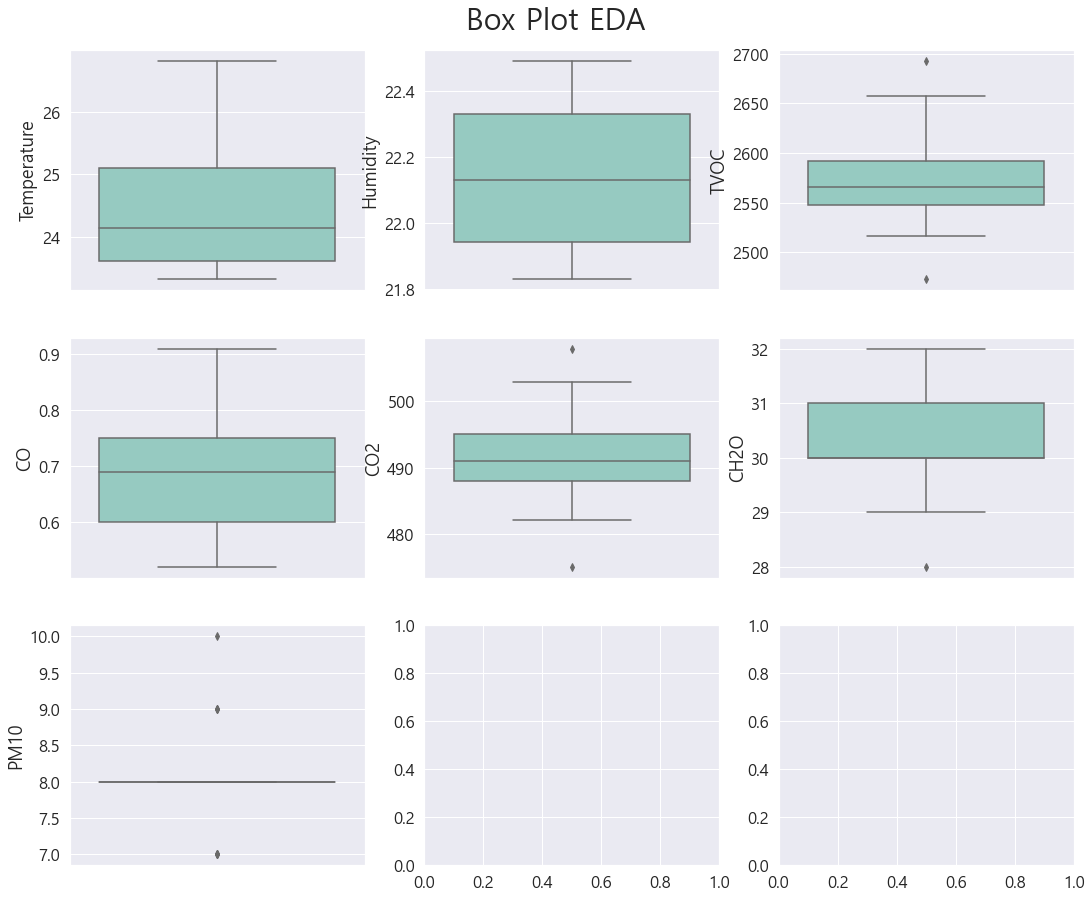

In [58]:
boxplotEDA(d11_4,d11_4.columns[1:],3,3)

### Data Merge

In [141]:
df_list = [d11_1,d11_2,d11_3,d11_4,d11_5]
df11 = pd.concat(df_list)
df11.rename(columns={'TsYMD':'Time'},inplace=True)
df11.reset_index(inplace=True,drop=True)
df11

Time  Temperature  Humidity    TVOC    CO    CO2  CH2O  \
0      2022-05-01 00:02        23.27     21.45  1377.0  0.99  545.0  25.0   
1      2022-05-01 00:04        20.51     21.46  1377.0  0.82  544.0  25.0   
2      2022-05-01 00:06        21.87     21.46  1383.0  0.50  546.0  25.0   
3      2022-05-01 00:08        21.87     21.48  1374.0  0.52  547.0  25.0   
4      2022-05-01 00:10        21.86     21.48  1380.0  0.37  548.0  25.0   
...                 ...          ...       ...     ...   ...    ...   ...   
13119  2022-05-19 11:10        26.78     21.07  3740.0  0.80  720.0  33.0   
13120  2022-05-19 11:12        28.23     21.03  3772.0  0.72  723.0  34.0   
13121  2022-05-19 11:15        28.32     21.02  3848.0  0.43  736.0  35.0   
13122  2022-05-19 11:17        28.37     20.99  3860.0  0.55  741.0  35.0   
13123  2022-05-19 11:20        27.05     20.98  3923.0  0.50  743.0  35.0   

       PM10  
0      18.0  
1      19.0  
2      18.0  
3      18.0  
4      18.0  
...     ...  
13119   5.0  
13120   5.0  
13121   5.0  
13122   5.0  
13123   5.0  

[13124 rows x 8 columns]

In [142]:
df11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13124 entries, 0 to 13123
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   Time         13124 non-null  period[T]
 1   Temperature  13124 non-null  float64  
 2   Humidity     13124 non-null  float64  
 3   TVOC         13124 non-null  float64  
 4   CO           13124 non-null  float64  
 5   CO2          13124 non-null  float64  
 6   CH2O         13124 non-null  float64  
 7   PM10         13124 non-null  float64  
dtypes: float64(7), period[T](1)
memory usage: 820.4 KB


### Difference

In [42]:
from statsmodels.tsa.stattools import adfuller, kpss

In [43]:
def adf_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] < pvalue:
       print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.")
    else:
       print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.")

In [44]:
def adf_test1(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       print(timeseries.name,f"정상성이 보장됩니다.")
    else:
       print(timeseries.name,f"정상성을 보장하지 못합니다.")

In [45]:
adf_test(df11['PM10'])

Results of Dickey-Fuller Test:
Test Statistic                    -5.360388
p-value                            0.000043
Lags Used                         34.000000
Number of Observations Used    13210.000000
Critical Value (1%)               -3.959455
Critical Value (5%)               -3.410822
Critical Value (10%)              -3.127246
dtype: float64
정상시계열이 아니라는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.


https://signature95.tistory.com/22 참고

In [46]:
for i in range(7):
  adf_test1(df11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


device11로 하였을 경우, CO,NO2,H2S,NH3를 제외한 모든 부분에서 정상성을 만족한다.

In [47]:
diff11=df11.copy()

In [48]:
# 전체 1차 차분
for i in range(7):
    diff11.iloc[:,1+i]=diff11.iloc[:,1+i].replace(diff11.iloc[:,1+i].diff().dropna())

In [49]:
for i in range(7):
  adf_test1(diff11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


In [50]:
diff11

Time  Temperature  Humidity   TVOC    CO  CO2  CH2O  PM10
0      2022-05-01 00:02        23.27     21.45   12.0  0.99  0.0   0.0  -1.0
1      2022-05-01 00:04        20.51     21.46   12.0  0.82  0.0   0.0   0.0
2      2022-05-01 00:06        21.87     21.46    3.0  0.50  2.0   0.0  -1.0
3      2022-05-01 00:08        21.87     21.48   15.0  0.52 -2.0   0.0  -1.0
4      2022-05-01 00:10        21.86     21.48   -2.0  0.37  1.0   0.0  -1.0
...                 ...          ...       ...    ...   ...  ...   ...   ...
13240  2022-05-19 11:12        28.23     21.03    3.0  0.72 -1.0   0.0   1.0
13241  2022-05-19 11:14        28.23     21.03    3.0  0.72 -1.0   0.0   1.0
13242  2022-05-19 11:16        28.32     21.02    1.0  0.43 -1.0   0.0   1.0
13243  2022-05-19 11:18        28.37     20.99    1.0  0.55 -2.0   0.0   1.0
13244  2022-05-19 11:20        27.05     20.98 -201.0  0.50  0.0   0.0   1.0

[13245 rows x 8 columns]

In [51]:
def diff1(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       timeseries=timeseries
    else:
       timeseries=timeseries.replace(timeseries.diff(1).dropna())
       
def diff2(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       timeseries=timeseries
    else:
       timeseries=timeseries.replace(timeseries.diff().diff().dropna())

In [52]:
for i in range(7):
    diff1(diff11.iloc[:,1+i])
    diff2(diff11.iloc[:,1+i])

In [53]:
for i in range(7):
    adf_test1(diff11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


### Outlier Process

In [64]:
def outliers_iqr(data):
  q1,q3 = np.percentile(data,[25,75])
  iqr=q3-q1
  lower_bound=  q1 - (iqr *1.5)
  upper_bound = q3 + (iqr *1.5)
  data[data>upper_bound] = np.nan #np.mean(data)
  data[data<lower_bound] = np.nan #np.mean(data)
  data.interpolate(method="ffill", inplace=True)
  data.interpolate(method="bfill", inplace=True)
  return data

In [65]:
for i in range(7):
    outliers_iqr(df11.iloc[:,1+i])

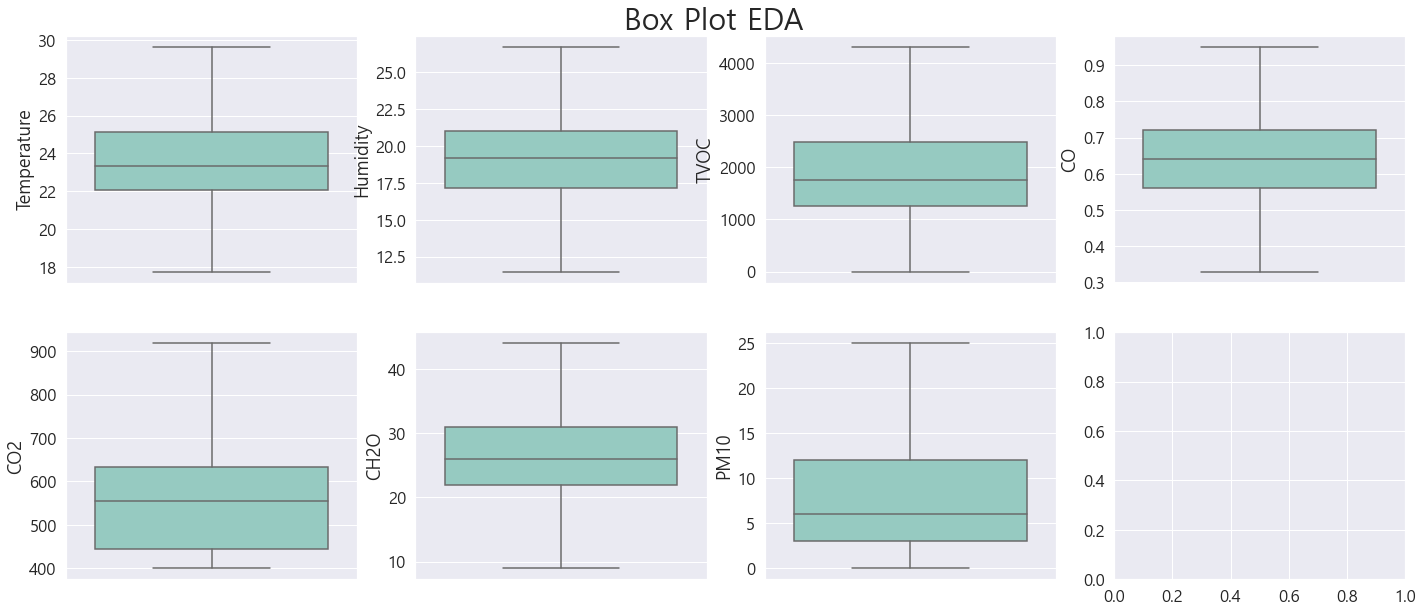

In [66]:
boxplotEDA(df11,df11.columns[1:],2,4)

## 3. Modeling

### Modeling Preparation

In [143]:
# DataFrame Time Indexing for Time Series Data
df11.set_index('Time',inplace=True)
diff11.set_index('Time',inplace=True)
print('df11 :',df11.shape)
print('diff11 :',diff11.shape)
df11.head()

NameError: name 'diff11' is not defined

In [139]:
# Data Load
df11 = pd.read_csv('data/df11.csv')
print(df11.shape)
df11.head(2)

(32144, 17)


DeviceName                              EntityId                TsYMD  \
0  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:01:08   
1  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:03:08   

   CH2O  PM2.5  PM10    TVOC    CO2  Temperature  Humidity  Radioactivity  \
0  25.0   10.0  18.0  1377.0  545.0        23.27     21.45            0.0   
1  25.0   10.0  19.0  1377.0  544.0        20.51     21.46            0.0   

   Sound    CO  Stink   NO2  H2S  NH3  
0   38.0  0.99   0.03  0.01  0.0  0.0  
1   33.0  0.82   0.03  0.01  0.0  0.0

In [138]:
# train_test_split | 0.8 : 0.2
X_train = df11.iloc[0:10500,:]
X_test = df11.iloc[10500:,:]
print('X_train.shape:',X_train.shape)
print('X_test.shape:',X_test.shape)

X_train.shape: (10500, 17)
X_test.shape: (21644, 17)


In [69]:
# Normalization
norm = MinMaxScaler()
X_train_scaled = norm.fit_transform(X_train)
X_test_scaled = norm.transform(X_test)
print('X_train_scaled.shape :',X_train_scaled.shape)
print('X_test_scaled.shape :',X_test_scaled.shape)

X_train_scaled.shape : (10500, 7)
X_test_scaled.shape : (2624, 7)


In [70]:
# Data Formating
train = np.reshape(X_train_scaled, (-1, 1,7))
test = np.reshape(X_test_scaled[:-1], (-1, 1,7))
print('train.shape :',train.shape)
print('test.shape :',test.shape)

train.shape : (10500, 1, 7)
test.shape : (2623, 1, 7)


### LSTE-AE Model Load

In [72]:
# # Encoder

# encoder_input = keras.layers.Input(shape=(train.shape[1],train.shape[2]))

# L1 = LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.00))(encoder_input)
# L2 = LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.00))(L1)
# L3 = LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.00))(L2)
# L4 = LSTM(4, activation='relu', return_sequences=False)(L3)
# L5 = keras.layers.RepeatVector(L3.shape[1])(L4)

# encoder_output = L5

In [74]:
# encoder = keras.Model(encoder_input, encoder_output)
# encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 128)            69632     
                                                                 
 lstm_17 (LSTM)              (None, 1, 64)             49408     
                                                                 
 lstm_18 (LSTM)              (None, 1, 32)             12416     
                                                                 
 lstm_19 (LSTM)              (None, 4)                 592       
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                           

<b>Decoder

In [75]:
# # Decoder
# decoder_input = keras.layers.Input(shape=(1,4))

# L6 = LSTM(4, activation='relu', return_sequences=True)(decoder_input)
# L7 = LSTM(32, activation='relu', return_sequences=True)(L6)
# L8 = LSTM(64, activation='relu', return_sequences=True)(L7)
# L9 = LSTM(128, activation='relu', return_sequences=True)(L8)
# output = keras.layers.TimeDistributed(Dense(train.shape[2]))(L9)

# decoder_output = output

In [77]:
# decoder = keras.Model(decoder_input, decoder_output)
# decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_21 (LSTM)              (None, 1, 32)             4736      
                                                                 
 lstm_22 (LSTM)              (None, 1, 64)             24832     
                                                                 
 lstm_23 (LSTM)              (None, 1, 128)            98816     
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 7)             903       
 tributed)                                                       
                                                           

<b>Connecting Encoder & Decoder

In [81]:
# # LSTM-AE = Encoder + Decoder

# encoder_in = keras.layers.Input(shape=(1,7))
# x = encoder(encoder_in)
# decoder_out = decoder(x)

# lstm_ae_model = keras.Model(encoder_in,decoder_out)
# lstm_ae_model.compile(optimizer='adam', loss='mse')
# lstm_ae_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 model_2 (Functional)        (None, 1, 4)              132048    
                                                                 
 model_4 (Functional)        (None, 1, 7)              129431    
                                                                 
Total params: 261,479
Trainable params: 261,479
Non-trainable params: 0
_________________________________________________________________


<b> LSTM-AE Model Training

In [82]:
# # Checkpoint Callback Function Definition
# checkpoint_dir = 'lstm-ae-checkpoint/'
# checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# # 5번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
#                      save_weights_only=True,
#                      save_best_only=True)

In [83]:
# # TQDM Tracking LSTN-AE Model Training
# nb_epochs = 30
# batch_size = 10
# tqdm_callback = tfa.callbacks.TQDMProgressBar()
# history = lstm_ae_model.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
#                     callbacks=[early_stopping, cp, tqdm_callback], validation_split=0.05).history

Epoch 1/30


Epoch 1/30


998/998 [==============================] - ETA: 0s - loss: 0.0393
Epoch 1: val_loss improved from inf to 0.02350, saving model to lstm-ae-checkpoint\cp-0001-0.02.ckpt

998/998 [==============================] - 52s 47ms/step - loss: 0.0393 - val_loss: 0.0235
Epoch 2/30


Epoch 2/30
998/998 [==============================] - ETA: 0s - loss: 0.0224
Epoch 2: val_loss improved from 0.02350 to 0.01464, saving model to lstm-ae-checkpoint\cp-0002-0.01.ckpt

998/998 [==============================] - 45s 45ms/step - loss: 0.0224 - val_loss: 0.0146
Epoch 3/30


Epoch 3/30
998/998 [==============================] - ETA: 0s - loss: 0.0163
Epoch 3: val_loss improved from 0.01464 to 0.00684, saving model to lstm-ae-checkpoint\cp-0003-0.01.ckpt

998/998 [==============================] - 45s 45ms/step - loss: 0.0163 - val_loss: 0.0068
Epoch 4/30


Epoch 4/30
998/998 [==============================] - ETA: 0s - loss: 0.0126
Epoch 4: val_loss improved from 0.00684 to 0.00680, saving model to lstm-ae-checkpoint\cp-0004-0.01.ckpt

998/998 [==============================] - 48s 48ms/step - loss: 0.0126 - val_loss: 0.0068
Epoch 5/30


Epoch 5/30
997/998 [============================>.] - ETA: 0s - loss: 0.0119
Epoch 5: val_loss did not improve from 0.00680

998/998 [==============================] - 47s 47ms/step - loss: 0.0119 - val_loss: 0.0075
Epoch 6/30


Epoch 6/30
998/998 [==============================] - ETA: 0s - loss: 0.0115
Epoch 6: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0115 - val_loss: 0.0072
Epoch 7/30


Epoch 7/30
997/998 [============================>.] - ETA: 0s - loss: 0.0111
Epoch 7: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0111 - val_loss: 0.0075
Epoch 8/30


Epoch 8/30
998/998 [==============================] - ETA: 0s - loss: 0.0108
Epoch 8: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0108 - val_loss: 0.0085
Epoch 9/30


Epoch 9/30
998/998 [==============================] - ETA: 0s - loss: 0.0105
Epoch 9: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0105 - val_loss: 0.0073
Epoch 10/30


Epoch 10/30
998/998 [==============================] - ETA: 0s - loss: 0.0102
Epoch 10: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 11/30


Epoch 11/30
998/998 [==============================] - ETA: 0s - loss: 0.0101
Epoch 11: val_loss did not improve from 0.00680

998/998 [==============================] - 46s 46ms/step - loss: 0.0101 - val_loss: 0.0076
Epoch 12/30


Epoch 12/30
998/998 [==============================] - ETA: 0s - loss: 0.0099
Epoch 12: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0099 - val_loss: 0.0074
Epoch 13/30


Epoch 13/30
997/998 [============================>.] - ETA: 0s - loss: 0.0099
Epoch 13: val_loss did not improve from 0.00680

998/998 [==============================] - 43s 43ms/step - loss: 0.0099 - val_loss: 0.0076
Epoch 14/30


Epoch 14/30
998/998 [==============================] - ETA: 0s - loss: 0.0097
Epoch 14: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0097 - val_loss: 0.0076



<b> LSTM-AE Model Save & Load

In [ ]:
# # 모델 저장
# model.save('lstm_model_save/lstm_ae_0621_0.026/')
# encoder.save('lstm_model_save/encoder_0621_0.026/')
# decoder.save('lstm_model_save/decoder_0621_0.026/')

In [71]:
lstm_ae_model = keras.models.load_model('lstm_model_save/lstm_ae_0621_0.026/')
encoder = keras.models.load_model('lstm_model_save/encoder_0621_0.026/')
decoder = keras.models.load_model('lstm_model_save/decoder_0621_0.026/')

<b>Model Performance Evaluation

Text(0.5, 1.0, 'Loss Curves')

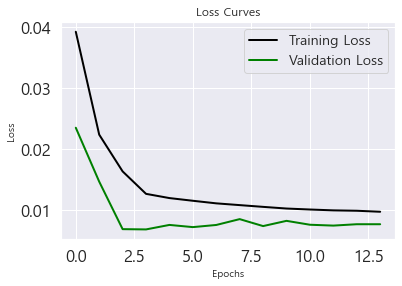

In [84]:
# # Loss curve of the training_set
# plt.figure(figsize=[6,4])
# plt.plot(history['loss'], 'black', linewidth=2.0)
# plt.plot(history['val_loss'], 'green', linewidth=2.0)
# plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
# plt.xlabel('Epochs', fontsize=10)
# plt.ylabel('Loss', fontsize=10)
# plt.title('Loss Curves', fontsize=12)

In [72]:
# Original Training DataSet
pd.DataFrame(X_train_scaled, columns = X_train.columns).head()

Temperature  Humidity      TVOC        CO       CO2      CH2O  PM10
0     0.428571  0.653972  0.319786  0.790323  0.285996  0.457143  0.72
1     0.180593  0.654629  0.319786  0.790323  0.284024  0.457143  0.76
2     0.302785  0.654629  0.321180  0.274194  0.287968  0.457143  0.72
3     0.302785  0.655942  0.319090  0.306452  0.289941  0.457143  0.72
4     0.301887  0.655942  0.320483  0.064516  0.291913  0.457143  0.72

In [73]:
# Prediction of Training DataSet
X_pred_train = lstm_ae_model.predict(train)

train_pred = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
train_pred = pd.DataFrame(train_pred, columns = X_train.columns)
train_pred.index = X_train.index
print('train_pred.shape :',train_pred.shape)
train_pred.head()

329/329 [==============================] - 4s 4ms/step
train_pred.shape : (10500, 7)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-01 00:02     0.291744  0.651807  0.324425  0.545216  0.292598   
2022-05-01 00:04     0.289871  0.657021  0.339587  0.581961  0.303140   
2022-05-01 00:06     0.299352  0.663714  0.320312  0.521593  0.287462   
2022-05-01 00:08     0.298647  0.664212  0.321779  0.525877  0.288451   
2022-05-01 00:10     0.313656  0.658779  0.313077  0.500865  0.302868   

                      CH2O      PM10  
Time                                  
2022-05-01 00:02  0.386801  0.731714  
2022-05-01 00:04  0.420315  0.719014  
2022-05-01 00:06  0.369455  0.755220  
2022-05-01 00:08  0.373008  0.753234  
2022-05-01 00:10  0.335401  0.773463

In [74]:
# Reconstruction Error Computation
def RE_SCORE(X_input, X_pred):
    score = pd.DataFrame(index = X_pred.index)
    score['RE_SCORE'] = np.mean(np.square(X_input-X_pred),axis=1)
    return score

In [75]:
# train_data reconstruction error
train_score = RE_SCORE(X_train_scaled, train_pred)
train_score = train_score.set_index(train_score.index)
train_score.head()

RE_SCORE
Time                      
2022-05-01 00:02  0.011993
2022-05-01 00:04  0.008451
2022-05-01 00:06  0.010033
2022-05-01 00:08  0.008061
2022-05-01 00:10  0.029772

In [81]:
# Reconstruction Error Threhold
upper, lower= np.quantile(train_score['RE_SCORE'].values,0.75), np.quantile(train_score['RE_SCORE'].values,0.25)
iqr = upper-lower
boundary = upper + iqr*1.5
print('boundary :',np.round(boundary,4))

boundary : 0.0265


In [83]:
train_score['Threshold'] = boundary
train_score.head()

RE_SCORE  Threshold
Time                                 
2022-05-01 00:02  0.011993   0.026458
2022-05-01 00:04  0.008451   0.026458
2022-05-01 00:06  0.010033   0.026458
2022-05-01 00:08  0.008061   0.026458
2022-05-01 00:10  0.029772   0.026458

In [182]:
# Reconstruction Error of Train Set Visualization
fig = px.scatter(train_score, x=train_score.index.to_timestamp(), y='RE_SCORE', title='Reconstruction Error of Train Set')
fig.add_trace(go.Scatter(x=train_score.index.to_timestamp(), y=train_score['Threshold'], name='Threshold',
                         line=dict(width=5,dash='dash',color=('rgb(237,37,75)'))))

In [184]:
fig = px.histogram(train_score, x="RE_SCORE", title ='Reconstruction Error Distribution of Train Set', marginal='box')
fig.add_vline(x=boundary, line_width=3, line_dash="dash", line_color="red",annotation_text="Threshold "+str(np.round(boundary,4)), annotation_position="bottom right")
fig.show()

In [122]:
# test_set evaluate
lstm_ae_model.evaluate(test,test)

82/82 [==============================] - 2s 4ms/step - loss: 0.0165


0.01647924818098545

In [123]:
# Original Test DataSet
pd.DataFrame(X_test_scaled, columns = X_test.columns).head()

Temperature  Humidity      TVOC        CO       CO2      CH2O  PM10
0     0.631626  0.257387  0.423131  0.435484  0.159763  0.514286  0.04
1     0.630728  0.257387  0.421737  0.483871  0.161736  0.514286  0.04
2     0.628931  0.257387  0.421505  0.548387  0.153846  0.514286  0.04
3     0.627134  0.258043  0.418254  0.758065  0.147929  0.514286  0.04
4     0.628032  0.258700  0.425917  0.645161  0.151874  0.514286  0.04

In [125]:
# Prediction of Test Set
X_pred_test = lstm_ae_model.predict(test)

test_pred = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
test_pred = pd.DataFrame(test_pred, columns = X_test.columns)
test_pred.index = X_test.iloc[:-1,:].index
print('test_pred.shape :',test_pred.shape)
test_pred.head()

82/82 [==============================] - 1s 6ms/step
test_pred.shape : (2623, 7)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-15 14:14     0.643098  0.363437  0.390858  0.485398  0.131273   
2022-05-15 14:16     0.646744  0.361786  0.390095  0.485885  0.132535   
2022-05-15 14:18     0.649517  0.357264  0.385034  0.486709  0.129856   
2022-05-15 14:20     0.666938  0.342210  0.371166  0.490259  0.127355   
2022-05-15 14:22     0.658443  0.352058  0.381325  0.488165  0.131360   

                      CH2O      PM10  
Time                                  
2022-05-15 14:14  0.486595  0.103842  
2022-05-15 14:16  0.484138  0.104102  
2022-05-15 14:18  0.477589  0.105288  
2022-05-15 14:20  0.455319  0.108703  
2022-05-15 14:22  0.469719  0.106295

In [166]:
# train_data reconstruction error
test_score = RE_SCORE(X_test_scaled[:-1], test_pred)
test_score = test_score.set_index(test_score.index.to_timestamp())
test_score.head()

RE_SCORE
Time                         
2022-05-15 14:14:00  0.002938
2022-05-15 14:16:00  0.002576
2022-05-15 14:18:00  0.003103
2022-05-15 14:20:00  0.013032
2022-05-15 14:22:00  0.006154

In [171]:
# total_score
total_score = train_score.copy()
total_score = pd.concat([total_score, test_score])
total_score['Anomaly'] = total_score['RE_SCORE'] > total_score['Threshold']
print('total_score.shape :',total_score.shape)
total_score.head()

total_score.shape : (13123, 3)


RE_SCORE  Threshold  Anomaly
Time                                          
2022-05-01 00:02  0.011993   0.026458    False
2022-05-01 00:04  0.008451   0.026458    False
2022-05-01 00:06  0.010033   0.026458    False
2022-05-01 00:08  0.008061   0.026458    False
2022-05-01 00:10  0.029772   0.026458     True

In [172]:
total_score['Anomaly'].value_counts()

False    12580
True       543
Name: Anomaly, dtype: int64

In [176]:
fig = px.line(total_score, x=total_score.index, y='RE_SCORE', title='Total Reconstruction Error & Threshold')
fig.add_trace(go.Scatter(x=total_score.index, y=total_score['Threshold'], name='Threshold',
                         line=dict(dash='dash',color=('rgb(237,37,75)'))))
fig.show()

AttributeError: 'Index' object has no attribute 'to_datetime'

In [142]:
fig = px.scatter(total_score, x=total_score.index, y='RE_SCORE', title='Total Reconstruction Error & Threshold')
fig.add_trace(go.Scatter(x=total_score.index, y=total_score['Threshold'], name='Threshold',
                         line=dict(dash='dash',color=('rgb(237,37,75)')))).update_traces(marker_size=4)
fig.show()

### Deep Compact Clustering

<b> Normal Data Extraction

In [193]:
train_set = pd.concat([pd.DataFrame(X_train_scaled,columns=X_train.columns,index=X_train.index),train_score],axis=1)
print('train_set.shape :',train_set.shape)
train_set.head(2)

train_set.shape : (10500, 8)


Temperature  Humidity     TVOC        CO       CO2  \
Time                                                                   
2022-05-01 00:02     0.428571  0.651133  0.31794  0.790323  0.285996   
2022-05-01 00:04     0.180593  0.651780  0.31794  0.790323  0.284024   

                      CH2O  PM10  RE_SCORE  
Time                                        
2022-05-01 00:02  0.457143  0.72  0.012375  
2022-05-01 00:04  0.457143  0.76  0.011970

In [194]:
Threshold = 0.026
normal = train_set[train_set['RE_SCORE'] <= Threshold]
print('normal.shape :',normal.shape)
normal.head(2)

normal.shape : (9961, 8)


Temperature  Humidity     TVOC        CO       CO2  \
Time                                                                   
2022-05-01 00:02     0.428571  0.651133  0.31794  0.790323  0.285996   
2022-05-01 00:04     0.180593  0.651780  0.31794  0.790323  0.284024   

                      CH2O  PM10  RE_SCORE  
Time                                        
2022-05-01 00:02  0.457143  0.72  0.012375  
2022-05-01 00:04  0.457143  0.76  0.011970

In [202]:
normal_data = normal.drop('RE_SCORE',axis=1).to_numpy().reshape(-1,1,7)
normal_data.shape

(9961, 1, 7)

<b> Embedded Feature Extraction

In [203]:
embedded = pd.DataFrame(encoder.predict(normal_data).reshape(-1,4))
embedded.head(1)

0         1         2    3
0  0.0  1.571795  2.434132  0.0

In [204]:
embedded = embedded.iloc[:,[1,2]].rename(columns={1:'comp1',2:'comp2'})
print('embedded.shape :',embedded.shape)
embedded.head()

embedded.shape : (9961, 2)


comp1     comp2
0  1.571795  2.434132
1  1.543575  2.601569
2  1.574901  2.395888
3  1.572893  2.406843
4  1.536987  2.633320

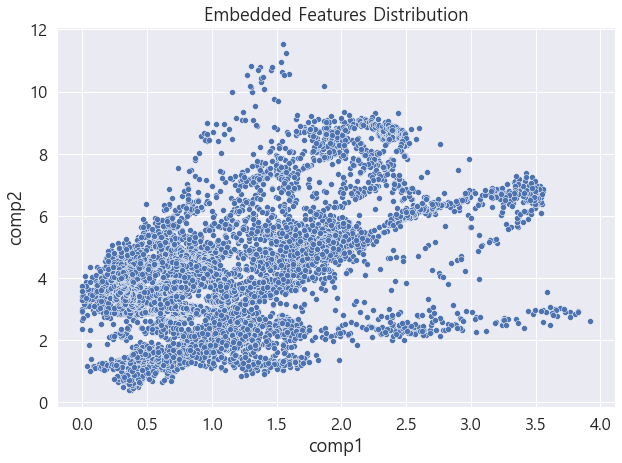

In [205]:
plt.figure(figsize=(10,7))
plt.title('Embedded Features Distribution')
sns.scatterplot(embedded.iloc[:,0], embedded.iloc[:,1], cmap=plt.get_cmap('Paired'))
plt.show()

<b> 계층적 군집분석 : Cluster Dendroram

In [206]:
linked = linkage(embedded,method='ward')

plt.figure(figsize=(10,7))
plt.title('Cluster Dendrogram')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

KeyboardInterrupt: 

<b> 합병형 군집분석 : AgglomerativeClustering

In [207]:
cluster = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='ward')
agglo_labels = cluster.fit_predict(embedded)

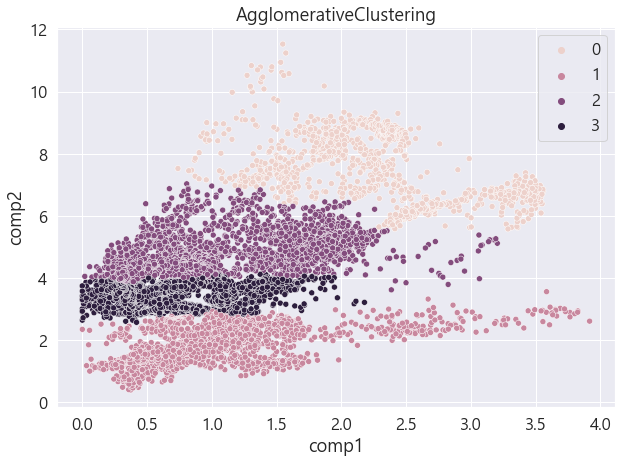

In [208]:
plt.figure(figsize=(10,7))
plt.title('AgglomerativeClustering')
sns.scatterplot(embedded.iloc[:,0], embedded.iloc[:,1], hue=agglo_labels)
plt.show()

<b> 비계층적 군집분석 : KMeans

In [209]:
kmeans = KMeans(n_clusters= 5, init='k-means++', max_iter = 300, random_state=42)
kmeans.fit(embedded)

KMeans(n_clusters=5, random_state=42)

In [211]:
kmeans_labels = kmeans.labels_
print(kmeans.inertia_)

4980.0283203125


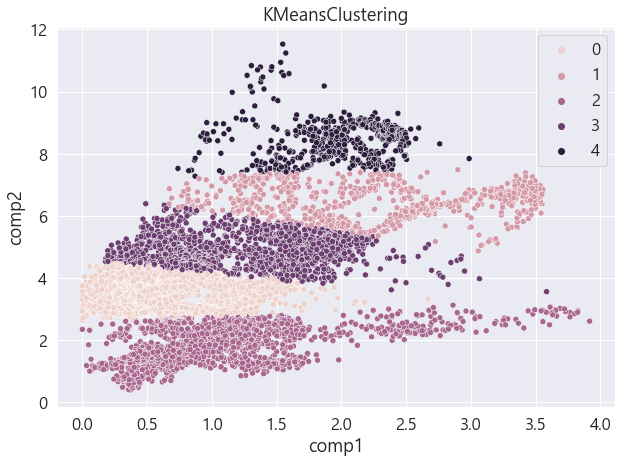

In [212]:
plt.figure(figsize=(10,7))
plt.title('KMeansClustering')
sns.scatterplot(embedded.iloc[:,0], embedded.iloc[:,1], hue=kmeans_labels)
plt.show()

<b> 혼합 분포 군집 : 가우시안 혼합 모델(Gaussian Mixture Model)

In [216]:
gmm = GaussianMixture(n_components=4, random_state=42, n_init=10)
gmm.fit(embedded)

GaussianMixture(n_components=4, n_init=10, random_state=42)

In [217]:
gmm_labels = gmm.predict(embedded)

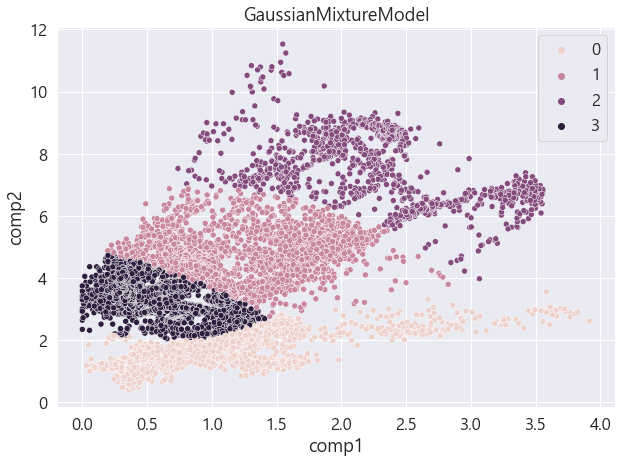

In [218]:
plt.figure(figsize=(10,7))
plt.title('GaussianMixtureModel')
sns.scatterplot(embedded.iloc[:,0], embedded.iloc[:,1], hue=gmm_labels)
plt.show()

<b> 밀도 기반 군집화 모델 : DBSCAN

In [223]:
dbscan = DBSCAN(eps = 0.3, min_samples=200, metric='euclidean')
dbscan_labels = dbscan.fit_predict(embedded)

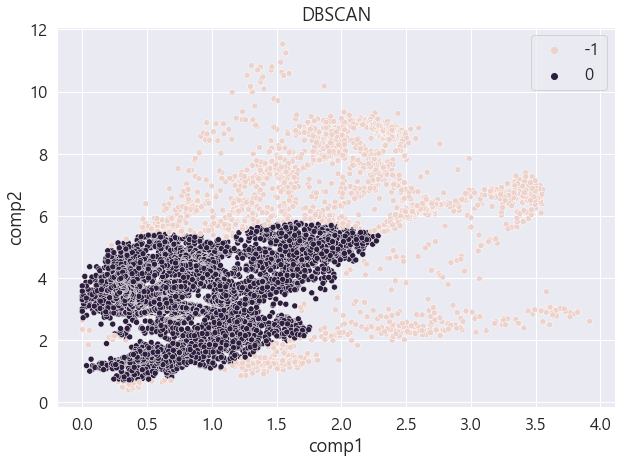

In [224]:
plt.figure(figsize=(10,7))
plt.title('DBSCAN')
sns.scatterplot(embedded.iloc[:,0], embedded.iloc[:,1], hue=dbscan_labels)
plt.show()

### OC-SVM Model